In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    
    # CMIP data       
    cmip_sst = torch.load("cmip_sst_data.pt")  ## 4546, 12, 24, 72
    cmip_t300 = torch.load("cmip_t300_data.pt")
    cmip_ua = torch.load("cmip_ua_data.pt")
    cmip_va = torch.load("cmip_va_data.pt")
    cmip_label = torch.load("cmip_label.pt")

    # SODA data    
    soda_data = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    soda_label = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    soda_sst = soda_data['sst'][:, :12].values.astype('float32')  # (100, 12, 24, 72)
    soda_t300 = soda_data['t300'][:, :12].values.astype('float32')
    soda_ua = soda_data['ua'][:, :12].values.astype('float32')
    soda_va = soda_data['va'][:, :12].values.astype('float32')
    soda_label = soda_label['nino'][:, 12:36].values.astype('float32')
    
    soda_sst = np.nan_to_num(soda_sst) # trans nan to 0
    soda_t300 = np.nan_to_num(soda_t300)
    soda_ua = np.nan_to_num(soda_ua)
    soda_va = np.nan_to_num(soda_va)

    dict_cmip = {
        'sst':cmip_sst,
        't300':cmip_t300,
        'ua':cmip_ua,
        'va': cmip_va,
        'label': cmip_label}
    dict_soda = {
        'sst':soda_sst,
        't300':soda_t300,
        'ua':soda_ua,
        'va': soda_va,
        'label': soda_label}
    
    cmip_dataset = EarthDataSet(dict_cmip)
    soda_dataset = EarthDataSet(dict_soda)
    
    train_1, valid_1 = random_split(cmip_dataset, [4545, 100])
    train_2, valid_2 = random_split(soda_dataset, [0, 100])
    
    train_dataset = train_1 + valid_1
    valid_dataset = valid_1
    valid_dataset_2 = valid_2
    
    print('Train samples: {}, Valid1 samples: {}, Valid2 samples: {}'.format(len(train_dataset), len(valid_dataset), len(valid_dataset_2)))
    
    return train_dataset, valid_dataset, valid_dataset_2

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset, valid_dataset_2 = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
valid_loader_2 = DataLoader(valid_dataset_2, batch_size=32, shuffle=False)

Train samples: 4645, Valid1 samples: 100, Valid2 samples: 100


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs, log_interval=20):
    best_score = -99
    loss_epoch = []
    score_epoch = []
    score_epoch_2 = []
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    best_score = score
    
    y_true_2, y_pred_2 = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader_2):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred_2.append(preds.cpu().detach().numpy())
        y_true_2.append(label.cpu().detach().numpy())

    y_true_2 = np.concatenate(y_true_2, axis=0)
    y_pred_2 = np.concatenate(y_pred_2, axis=0)
    x_month = np.arange(24)
    score_2 = eval_score(y_true_2, y_pred_2)
    print('Epoch: {}, Valid Score: {}, Valid Score 2: {}\n'.format(epoch+1,score,score_2))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):   
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%log_interval == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds.cpu().detach().numpy())
            y_true.append(label.cpu().detach().numpy())

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        score_epoch.append(score)
        
        y_true_2, y_pred_2 = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader_2):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred_2.append(preds.cpu().detach().numpy())
            y_true_2.append(label.cpu().detach().numpy())

        y_true_2 = np.concatenate(y_true_2, axis=0)
        y_pred_2 = np.concatenate(y_pred_2, axis=0)
        x_month = np.arange(24)
        score_2 = eval_score(y_true_2, y_pred_2)
        score_epoch_2.append(score_2)
        print('Epoch: {}, Valid Score: {}, Valid Score 2: {}\n'.format(epoch+1,score,score_2))    
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(10):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        j = 0
        for i in range(10, 23):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true_2[j],color='red')
            plt.plot(x_month, y_pred_2[j],color='blue')
            j += 1
        plt.subplot(5,5,24)
        plt.plot(np.arange(len(loss_epoch))[:20],loss_epoch[-20:])
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(score_epoch)),score_epoch)
        plt.plot(np.arange(len(score_epoch)),score_epoch_2)
        plt.tight_layout()
        plt.show()
        
    max_score = max(score_epoch)
    max_epoch = score_epoch.index(max_score) + 1
    print("max score: {} at eopch {}".format(max_score, max_epoch))
    max_score_2 = max(score_epoch_2)
    max_epoch_2 = score_epoch_2.index(max_score_2) + 1
    print("max score 2: {} at eopch {}".format(max_score_2, max_epoch_2))

In [24]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=1, kernel_size=(4,8))) 
        
        self.batch_norm = nn.BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 64))
        self.linear = nn.Linear(64, 24)

    def forward(self, sst, t300, ua, va):
        x = self.conv(sst)  # batch * 12 * (24 - 2) * (72 -2)

        x = torch.flatten(x, start_dim=2)  # batch * 12 * 1540
        
        x = self.batch_norm(x)
        x = self.avgpool(x).squeeze(dim=-2)
        x = self.linear(x)
        return x

In [25]:
'''
(1, 128): max score: 44.37983631523829 at eopch 49; max score 2: 5.373897295704463 at eopch 20
(1, 64):  max score: 38.86314433249353 at eopch 48, max score 2: 12.67324381162318 at eopch 50



'''

'\n(1, 128): max score: 44.37983631523829 at eopch 49; max score 2: 5.373897295704463 at eopch 20\n(1, 64):  max score: 38.86314433249353 at eopch 48, max score 2: 12.67324381162318 at eopch 50\n\n\n\n'

In [26]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

gpu_ids = [i for i in range(int(torch.cuda.device_count()))]
model = torch.nn.DataParallel(model.to("cuda:0"), device_ids=gpu_ids)
loss_fn = loss_fn.to(device)

In [27]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

DataParallel : all params: 0.001947M


In [28]:
model

DataParallel(
  (module): CNN_Model(
    (conv): Sequential(
      (0): Conv2d(12, 1, kernel_size=(4, 8), stride=(1, 1))
    )
    (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 64))
    (linear): Linear(in_features=64, out_features=24, bias=True)
  )
)

acskill_socre:1.050682016769102, rmse_score:19.936322174959738
acskill_socre:-6.224817634717767, rmse_score:18.859964754311452
Epoch: 0, Valid Score: -18.885640158190636, Valid Score 2: -25.08478238902922

Step: 0, Train Loss: 0.7523807287216187
Step: 20, Train Loss: 0.7976822853088379
Step: 40, Train Loss: 0.6743358969688416
Step: 60, Train Loss: 0.8188998103141785
Step: 80, Train Loss: 0.612458348274231
Step: 100, Train Loss: 0.982738196849823
Step: 120, Train Loss: 0.7789011001586914
Step: 140, Train Loss: 0.7294263243675232
Epoch: 1, Train loss: 0.769790675133875
acskill_socre:-0.2665732134442279, rmse_score:19.806326569371098
acskill_socre:0.18548498721032716, rmse_score:19.048839100306605
Epoch: 1, Valid Score: -20.072899782815327, Valid Score 2: -18.86335411309628



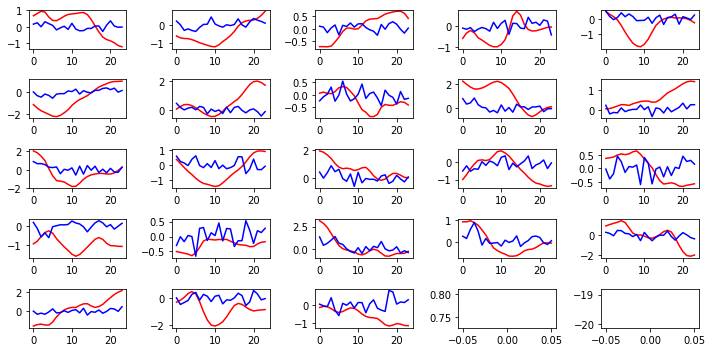

Step: 0, Train Loss: 0.768596351146698
Step: 20, Train Loss: 0.7637920379638672
Step: 40, Train Loss: 0.7526556849479675
Step: 60, Train Loss: 0.6357564926147461
Step: 80, Train Loss: 0.7607887983322144
Step: 100, Train Loss: 0.7473591566085815
Step: 120, Train Loss: 0.5894253253936768
Step: 140, Train Loss: 0.847469687461853
Epoch: 2, Train loss: 0.7092342880898959
acskill_socre:13.794473831885847, rmse_score:19.003489237023256
acskill_socre:3.400692537117611, rmse_score:18.81559520166618
Epoch: 2, Valid Score: -5.209015405137409, Valid Score 2: -15.41490266454857

Model saved successfully


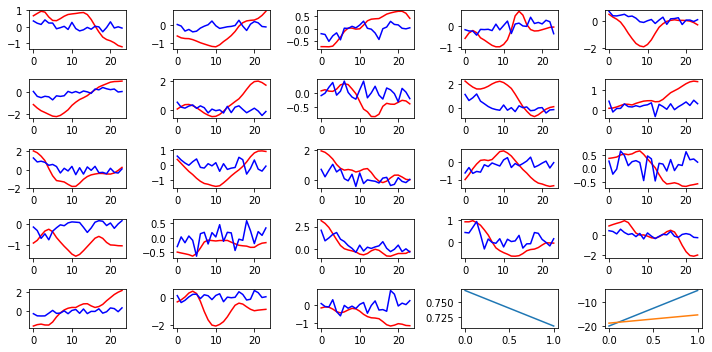

Step: 0, Train Loss: 0.6599509119987488
Step: 20, Train Loss: 0.6338456869125366
Step: 40, Train Loss: 0.738210141658783
Step: 60, Train Loss: 0.874828040599823
Step: 80, Train Loss: 0.6558235883712769
Step: 100, Train Loss: 0.5578362941741943
Step: 120, Train Loss: 0.7080144882202148
Step: 140, Train Loss: 0.7229770421981812
Epoch: 3, Train loss: 0.6495649590067667
acskill_socre:29.732124709786593, rmse_score:18.094818453749387
acskill_socre:6.728887029373248, rmse_score:18.924360572089817
Epoch: 3, Valid Score: 11.637306256037206, Valid Score 2: -12.19547354271657

Model saved successfully


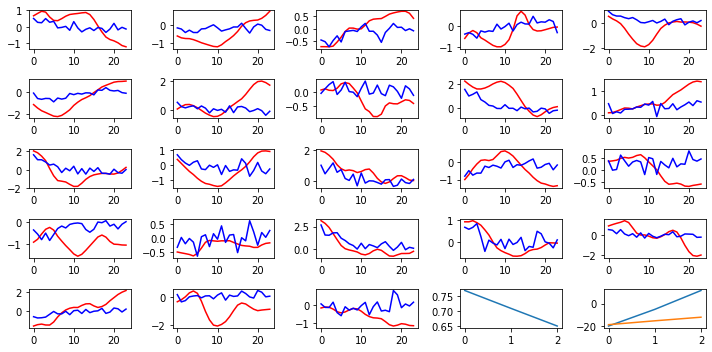

Step: 0, Train Loss: 0.6071341037750244
Step: 20, Train Loss: 0.8608626127243042
Step: 40, Train Loss: 0.7171610593795776
Step: 60, Train Loss: 0.5251122713088989
Step: 80, Train Loss: 0.7171916961669922
Step: 100, Train Loss: 0.6743282675743103
Step: 120, Train Loss: 0.4939366281032562
Step: 140, Train Loss: 0.7349168658256531
Epoch: 4, Train loss: 0.6131243121950594
acskill_socre:37.98975509106853, rmse_score:17.39775172351759
acskill_socre:10.102485851947781, rmse_score:18.65764322037283
Epoch: 4, Valid Score: 20.59200336755094, Valid Score 2: -8.555157368425048

Model saved successfully


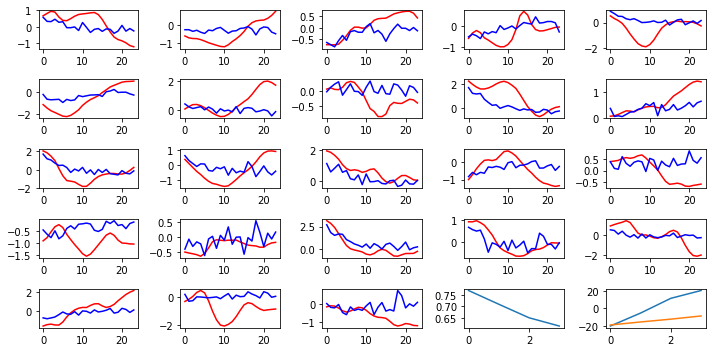

Step: 0, Train Loss: 0.7150887250900269
Step: 20, Train Loss: 0.45530128479003906
Step: 40, Train Loss: 0.6916084289550781
Step: 60, Train Loss: 0.6196174621582031
Step: 80, Train Loss: 0.6730175018310547
Step: 100, Train Loss: 0.6339128017425537
Step: 120, Train Loss: 0.5194727182388306
Step: 140, Train Loss: 0.6830834746360779
Epoch: 5, Train loss: 0.5846067258756454
acskill_socre:41.74721993359407, rmse_score:17.025309187016948
acskill_socre:13.723789423082998, rmse_score:18.25592749640489
Epoch: 5, Valid Score: 24.72191074657712, Valid Score 2: -4.532138073321892

Model saved successfully


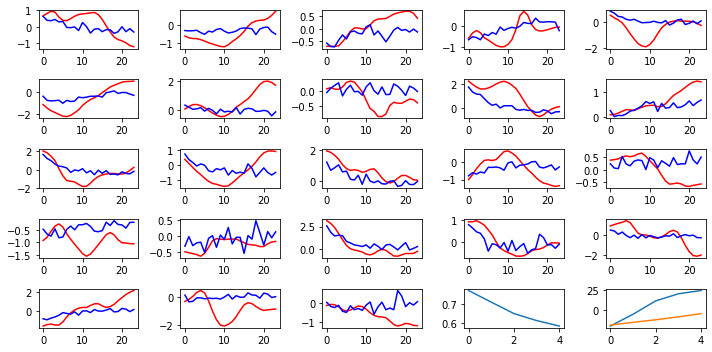

Step: 0, Train Loss: 0.95949387550354
Step: 20, Train Loss: 0.4666098952293396
Step: 40, Train Loss: 0.5458500385284424
Step: 60, Train Loss: 0.6925185918807983
Step: 80, Train Loss: 0.5003588199615479
Step: 100, Train Loss: 0.4409294128417969
Step: 120, Train Loss: 0.5414404273033142
Step: 140, Train Loss: 0.4979155659675598
Epoch: 6, Train loss: 0.5667229921442188
acskill_socre:45.07654523731003, rmse_score:16.72625011680738
acskill_socre:16.176333533953922, rmse_score:18.253172197028952
Epoch: 6, Valid Score: 28.35029512050265, Valid Score 2: -2.07683866307503

Model saved successfully


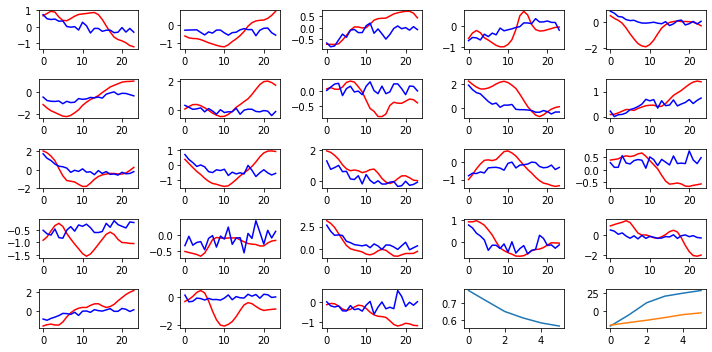

Step: 0, Train Loss: 0.5698788166046143
Step: 20, Train Loss: 0.6162787675857544
Step: 40, Train Loss: 0.469798743724823
Step: 60, Train Loss: 0.5082722902297974
Step: 80, Train Loss: 0.5663144588470459
Step: 100, Train Loss: 0.6806908845901489
Step: 120, Train Loss: 0.5263205170631409
Step: 140, Train Loss: 0.6650682687759399
Epoch: 7, Train loss: 0.5542510323328514
acskill_socre:46.955933504144994, rmse_score:16.455655606073677
acskill_socre:18.22821980035512, rmse_score:18.077441990841656
Epoch: 7, Valid Score: 30.500277898071317, Valid Score 2: 0.15077780951346398

Model saved successfully


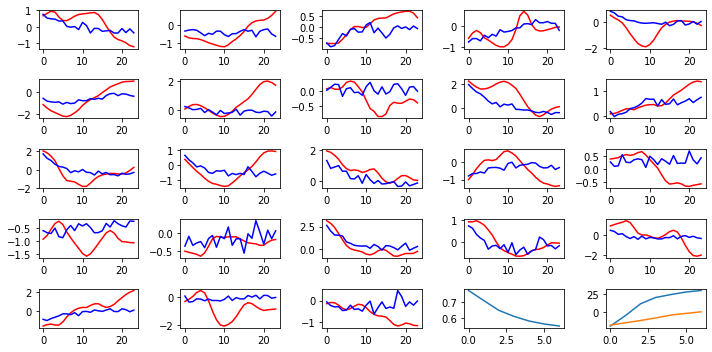

Step: 0, Train Loss: 0.5706034302711487
Step: 20, Train Loss: 0.4569905996322632
Step: 40, Train Loss: 0.6074662208557129
Step: 60, Train Loss: 0.5110554099082947
Step: 80, Train Loss: 0.8102318644523621
Step: 100, Train Loss: 0.540795087814331
Step: 120, Train Loss: 0.4272671639919281
Step: 140, Train Loss: 0.5818203687667847
Epoch: 8, Train loss: 0.5455402784968075
acskill_socre:48.010203766371134, rmse_score:16.27583530849883
acskill_socre:19.866637695142877, rmse_score:17.939792008543364
Epoch: 8, Valid Score: 31.734368457872304, Valid Score 2: 1.9268456865995134

Model saved successfully


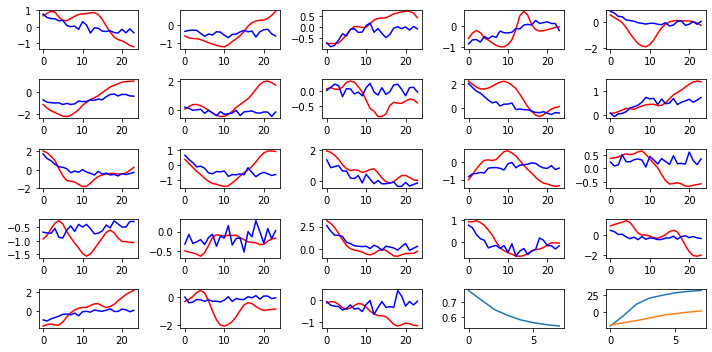

Step: 0, Train Loss: 0.24759280681610107
Step: 20, Train Loss: 0.6219123005867004
Step: 40, Train Loss: 0.4780840277671814
Step: 60, Train Loss: 0.6439430117607117
Step: 80, Train Loss: 0.5405703783035278
Step: 100, Train Loss: 0.45281824469566345
Step: 120, Train Loss: 0.5006123185157776
Step: 140, Train Loss: 0.5951777696609497
Epoch: 9, Train loss: 0.5334661041628824
acskill_socre:48.93509676101752, rmse_score:16.159420550878426
acskill_socre:21.12269558339707, rmse_score:17.91077494092083
Epoch: 9, Valid Score: 32.775676210139096, Valid Score 2: 3.2119206424762403

Model saved successfully


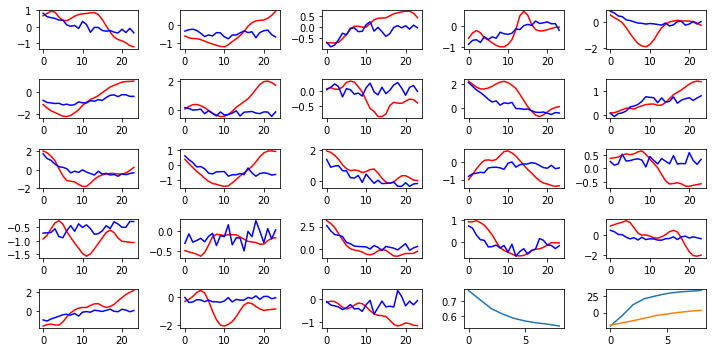

Step: 0, Train Loss: 0.474322646856308
Step: 20, Train Loss: 0.5806069374084473
Step: 40, Train Loss: 0.3477482199668884
Step: 60, Train Loss: 0.5200364589691162
Step: 80, Train Loss: 0.5625556707382202
Step: 100, Train Loss: 0.6985647082328796
Step: 120, Train Loss: 0.45459455251693726
Step: 140, Train Loss: 0.3715502619743347
Epoch: 10, Train loss: 0.5289522207354846
acskill_socre:49.269465617457556, rmse_score:16.02244341163827
acskill_socre:22.218039645709187, rmse_score:17.68323892901561
Epoch: 10, Valid Score: 33.247022205819285, Valid Score 2: 4.534800716693578

Model saved successfully


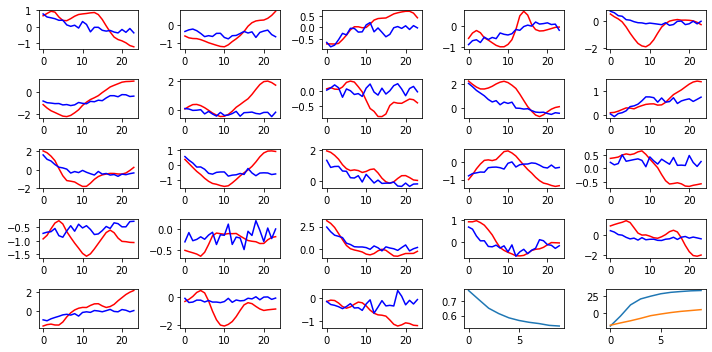

Step: 0, Train Loss: 0.49354881048202515
Step: 20, Train Loss: 0.6180793642997742
Step: 40, Train Loss: 0.6060860753059387
Step: 60, Train Loss: 0.48211371898651123
Step: 80, Train Loss: 0.6150320768356323
Step: 100, Train Loss: 0.49797242879867554
Step: 120, Train Loss: 0.3849533498287201
Step: 140, Train Loss: 0.6054763793945312
Epoch: 11, Train loss: 0.5211892548489244
acskill_socre:50.21896400759762, rmse_score:15.88708233569872
acskill_socre:22.33757664695863, rmse_score:17.76149889628321
Epoch: 11, Valid Score: 34.3318816718989, Valid Score 2: 4.57607775067542

Model saved successfully


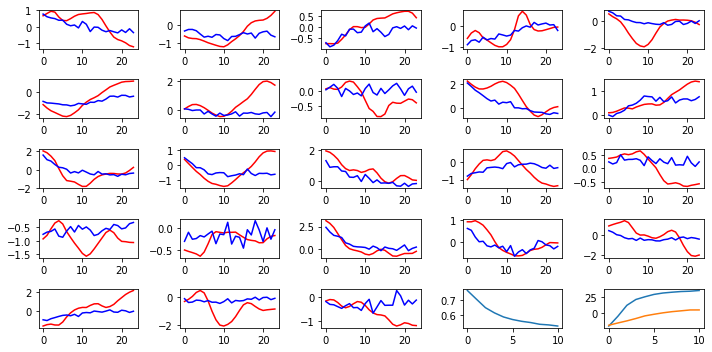

Step: 0, Train Loss: 0.5248775482177734
Step: 20, Train Loss: 0.4733511209487915
Step: 40, Train Loss: 0.6662484407424927
Step: 60, Train Loss: 0.6780783534049988
Step: 80, Train Loss: 0.49258655309677124
Step: 100, Train Loss: 0.37228721380233765
Step: 120, Train Loss: 0.5314174890518188
Step: 140, Train Loss: 0.39466723799705505
Epoch: 12, Train loss: 0.516967598910201
acskill_socre:50.16582795895373, rmse_score:15.84200626000702
acskill_socre:23.938272412558437, rmse_score:17.47668777933867
Epoch: 12, Valid Score: 34.32382169894671, Valid Score 2: 6.461584633219768



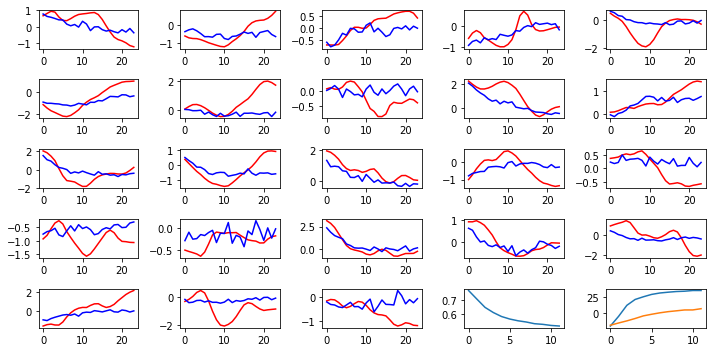

Step: 0, Train Loss: 0.4302893579006195
Step: 20, Train Loss: 0.477557897567749
Step: 40, Train Loss: 0.5476168990135193
Step: 60, Train Loss: 0.48688825964927673
Step: 80, Train Loss: 0.5242859721183777
Step: 100, Train Loss: 0.4586573541164398
Step: 120, Train Loss: 0.5793450474739075
Step: 140, Train Loss: 0.8185822367668152
Epoch: 13, Train loss: 0.5156192661148228
acskill_socre:50.772551889105365, rmse_score:15.755705484426494
acskill_socre:23.910996971561904, rmse_score:17.502480701949043
Epoch: 13, Valid Score: 35.01684640467887, Valid Score 2: 6.408516269612861

Model saved successfully


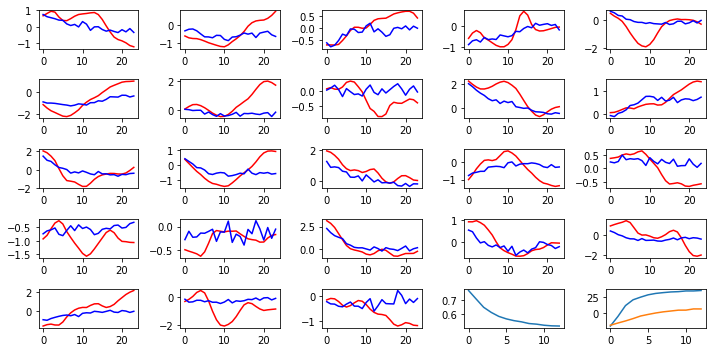

Step: 0, Train Loss: 0.7192463278770447
Step: 20, Train Loss: 0.45251184701919556
Step: 40, Train Loss: 0.565403401851654
Step: 60, Train Loss: 0.5014231204986572
Step: 80, Train Loss: 0.43253111839294434
Step: 100, Train Loss: 0.6321700215339661
Step: 120, Train Loss: 0.4927480220794678
Step: 140, Train Loss: 0.5419240593910217
Epoch: 14, Train loss: 0.5086274184796908
acskill_socre:51.06299874293592, rmse_score:15.689201187136305
acskill_socre:24.204997179938776, rmse_score:17.548490428182586
Epoch: 14, Valid Score: 35.37379755579961, Valid Score 2: 6.65650675175619

Model saved successfully


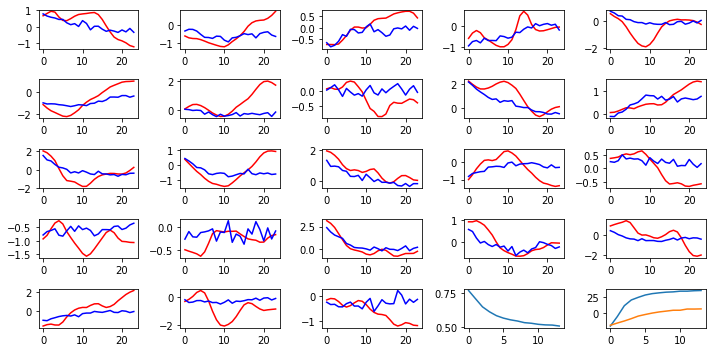

Step: 0, Train Loss: 0.5752264261245728
Step: 20, Train Loss: 0.5741854310035706
Step: 40, Train Loss: 0.827170729637146
Step: 60, Train Loss: 0.4707206189632416
Step: 80, Train Loss: 0.5213137865066528
Step: 100, Train Loss: 0.42376670241355896
Step: 120, Train Loss: 0.4932570457458496
Step: 140, Train Loss: 0.5680534243583679
Epoch: 15, Train loss: 0.5081802490231109
acskill_socre:51.44640367220242, rmse_score:15.61286718570955
acskill_socre:24.366643093122665, rmse_score:17.512219532390898
Epoch: 15, Valid Score: 35.833536486492875, Valid Score 2: 6.854423560731767

Model saved successfully


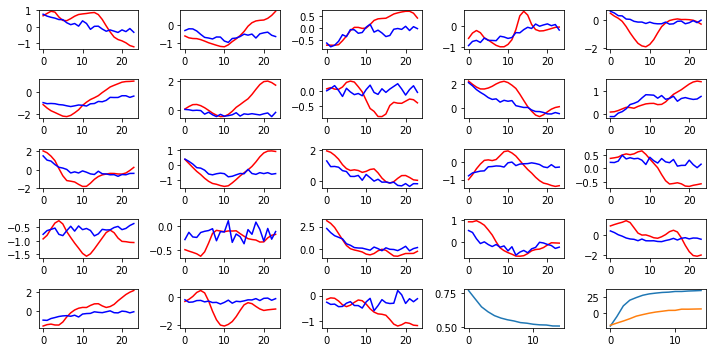

Step: 0, Train Loss: 0.35178861021995544
Step: 20, Train Loss: 0.5657989978790283
Step: 40, Train Loss: 0.5823033452033997
Step: 60, Train Loss: 0.42146191000938416
Step: 80, Train Loss: 0.4961545467376709
Step: 100, Train Loss: 0.5110270380973816
Step: 120, Train Loss: 0.5030298233032227
Step: 140, Train Loss: 0.39751332998275757
Epoch: 16, Train loss: 0.5082737615663712
acskill_socre:51.327037380692424, rmse_score:15.589948647409791
acskill_socre:25.569095281906534, rmse_score:17.28979258858038
Epoch: 16, Valid Score: 35.73708873328263, Valid Score 2: 8.279302693326155



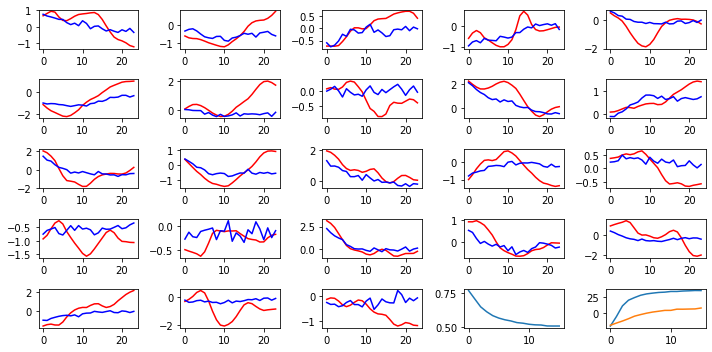

Step: 0, Train Loss: 0.5900121927261353
Step: 20, Train Loss: 0.45202332735061646
Step: 40, Train Loss: 0.5866979360580444
Step: 60, Train Loss: 0.39632338285446167
Step: 80, Train Loss: 0.418895959854126
Step: 100, Train Loss: 0.4097382426261902
Step: 120, Train Loss: 0.38975653052330017
Step: 140, Train Loss: 0.611229419708252
Epoch: 17, Train loss: 0.5057173148818213
acskill_socre:51.5203910798911, rmse_score:15.53631400817921
acskill_socre:26.08559922678211, rmse_score:17.238176959153094
Epoch: 17, Valid Score: 35.98407707171189, Valid Score 2: 8.847422267629018

Model saved successfully


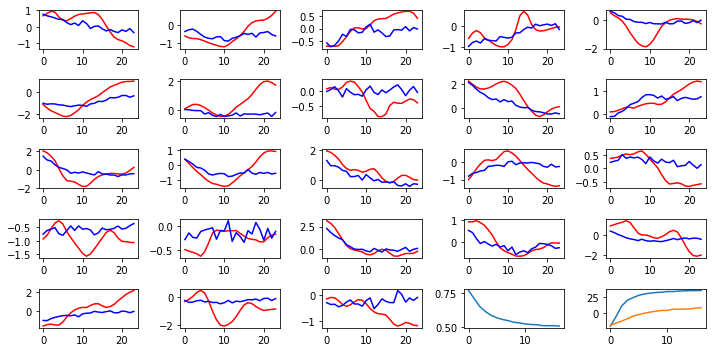

Step: 0, Train Loss: 0.37806349992752075
Step: 20, Train Loss: 0.503354549407959
Step: 40, Train Loss: 0.40511029958724976
Step: 60, Train Loss: 0.39332735538482666
Step: 80, Train Loss: 0.5231478810310364
Step: 100, Train Loss: 0.625809907913208
Step: 120, Train Loss: 0.6434582471847534
Step: 140, Train Loss: 0.4897807538509369
Epoch: 18, Train loss: 0.5042442854953139
acskill_socre:51.417402395306794, rmse_score:15.540287124841937
acskill_socre:26.745829467314923, rmse_score:17.096600473450042
Epoch: 18, Valid Score: 35.877115270464856, Valid Score 2: 9.649228993864881



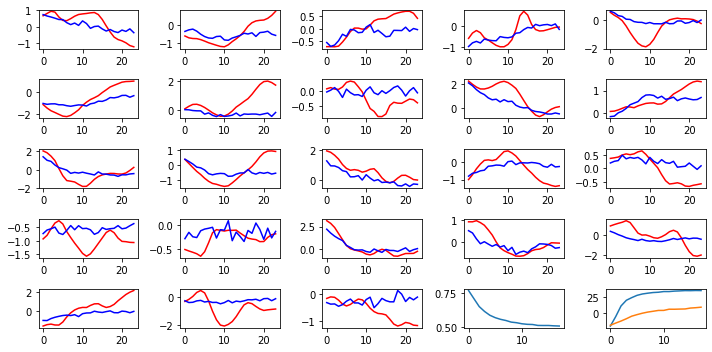

Step: 0, Train Loss: 0.560320258140564
Step: 20, Train Loss: 0.4859328269958496
Step: 40, Train Loss: 0.5414459705352783
Step: 60, Train Loss: 0.5037072896957397
Step: 80, Train Loss: 0.40682023763656616
Step: 100, Train Loss: 0.6963223814964294
Step: 120, Train Loss: 0.5518871545791626
Step: 140, Train Loss: 0.555996835231781
Epoch: 19, Train loss: 0.5015208810976107
acskill_socre:51.53255508697403, rmse_score:15.503714767768747
acskill_socre:26.71320197778681, rmse_score:17.15355457262823
Epoch: 19, Valid Score: 36.02884031920528, Valid Score 2: 9.559647405158579

Model saved successfully


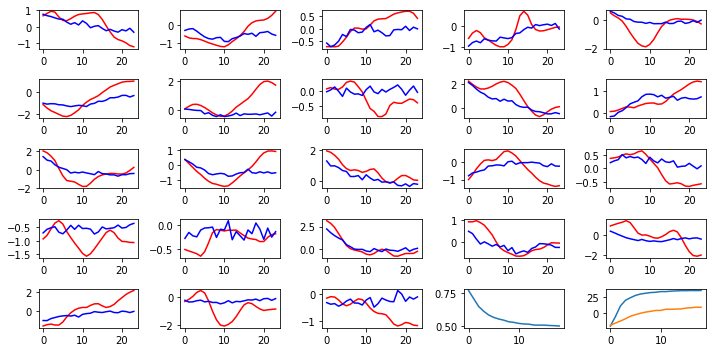

Step: 0, Train Loss: 0.5082530975341797
Step: 20, Train Loss: 0.7110087275505066
Step: 40, Train Loss: 0.397530734539032
Step: 60, Train Loss: 0.4674724340438843
Step: 80, Train Loss: 0.5984537601470947
Step: 100, Train Loss: 0.4796501100063324
Step: 120, Train Loss: 0.4651213586330414
Step: 140, Train Loss: 0.4576951861381531
Epoch: 20, Train loss: 0.5008359414665666
acskill_socre:51.804848699422834, rmse_score:15.457427779897229
acskill_socre:26.870520343933197, rmse_score:17.213945507843032
Epoch: 20, Valid Score: 36.347420919525604, Valid Score 2: 9.656574836090165

Model saved successfully


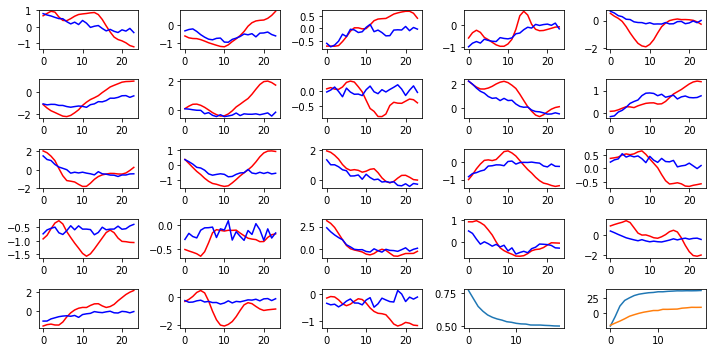

Step: 0, Train Loss: 0.5162553787231445
Step: 20, Train Loss: 0.4200529456138611
Step: 40, Train Loss: 0.45045584440231323
Step: 60, Train Loss: 0.5825352072715759
Step: 80, Train Loss: 0.5815898180007935
Step: 100, Train Loss: 0.36132490634918213
Step: 120, Train Loss: 0.5380215048789978
Step: 140, Train Loss: 0.5685747861862183
Epoch: 21, Train loss: 0.49963251184927276
acskill_socre:51.90630243265197, rmse_score:15.480097894509019
acskill_socre:26.657479308328284, rmse_score:17.227985788813985
Epoch: 21, Valid Score: 36.426204538142954, Valid Score 2: 9.429493519514299

Model saved successfully


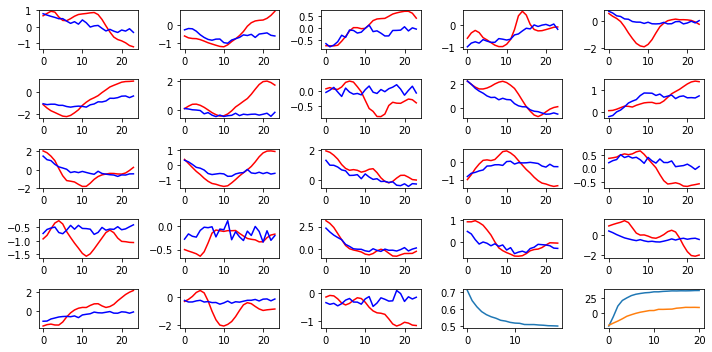

Step: 0, Train Loss: 0.5524857044219971
Step: 20, Train Loss: 0.4572100341320038
Step: 40, Train Loss: 0.5244636535644531
Step: 60, Train Loss: 0.6288639307022095
Step: 80, Train Loss: 0.49983441829681396
Step: 100, Train Loss: 0.46683168411254883
Step: 120, Train Loss: 0.42362937331199646
Step: 140, Train Loss: 0.496288001537323
Epoch: 22, Train loss: 0.49906106946403034
acskill_socre:52.219699181763204, rmse_score:15.416910884946729
acskill_socre:27.07176477391939, rmse_score:17.14973707039415
Epoch: 22, Valid Score: 36.80278829681647, Valid Score 2: 9.922027703525242

Model saved successfully


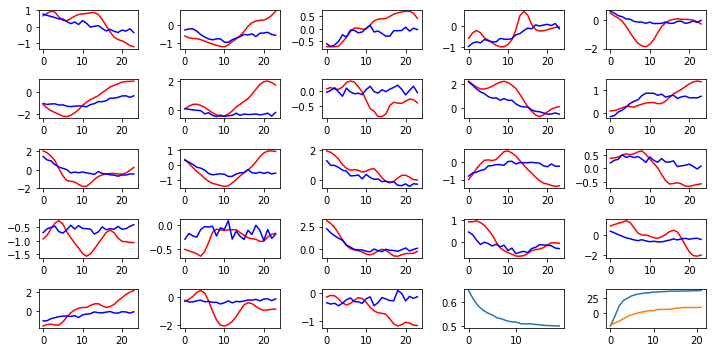

Step: 0, Train Loss: 0.6541169881820679
Step: 20, Train Loss: 0.43022602796554565
Step: 40, Train Loss: 0.6030905246734619
Step: 60, Train Loss: 0.5370627641677856
Step: 80, Train Loss: 0.3958885371685028
Step: 100, Train Loss: 0.4891700744628906
Step: 120, Train Loss: 0.4541940689086914
Step: 140, Train Loss: 0.4557000398635864
Epoch: 23, Train loss: 0.49896162993287385
acskill_socre:52.049060533738654, rmse_score:15.423667820379471
acskill_socre:27.441040990897903, rmse_score:17.12030916003628
Epoch: 23, Valid Score: 36.62539271335918, Valid Score 2: 10.320731830861625



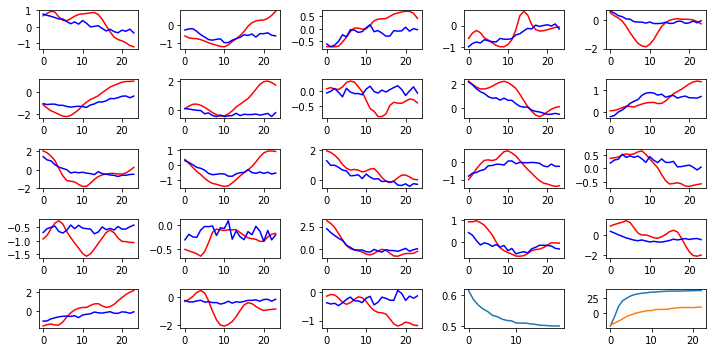

Step: 0, Train Loss: 0.4746144711971283
Step: 20, Train Loss: 0.4567970037460327
Step: 40, Train Loss: 0.5645267963409424
Step: 60, Train Loss: 0.4612608850002289
Step: 80, Train Loss: 0.5456726551055908
Step: 100, Train Loss: 0.4007863998413086
Step: 120, Train Loss: 0.5086796283721924
Step: 140, Train Loss: 0.6690292358398438
Epoch: 24, Train loss: 0.49732904850620113
acskill_socre:52.26042146408119, rmse_score:15.38682485580213
acskill_socre:28.058631267945447, rmse_score:16.928167448127457
Epoch: 24, Valid Score: 36.87359660827906, Valid Score 2: 11.13046381981799

Model saved successfully


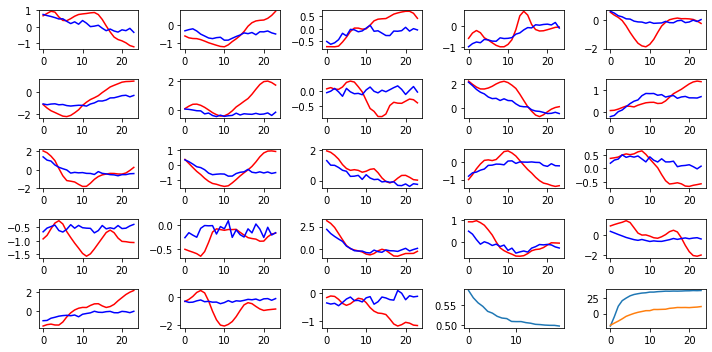

Step: 0, Train Loss: 0.40503424406051636
Step: 20, Train Loss: 0.7103499174118042
Step: 40, Train Loss: 0.4446919858455658
Step: 60, Train Loss: 0.506493091583252
Step: 80, Train Loss: 0.4579014182090759
Step: 100, Train Loss: 0.42582234740257263
Step: 120, Train Loss: 0.5301724672317505
Step: 140, Train Loss: 0.45543143153190613
Epoch: 25, Train loss: 0.49809168524121583
acskill_socre:52.43031477347465, rmse_score:15.367200578658384
acskill_socre:27.648405197943298, rmse_score:16.987528491129947
Epoch: 25, Valid Score: 37.063114194816265, Valid Score 2: 10.660876706813351

Model saved successfully


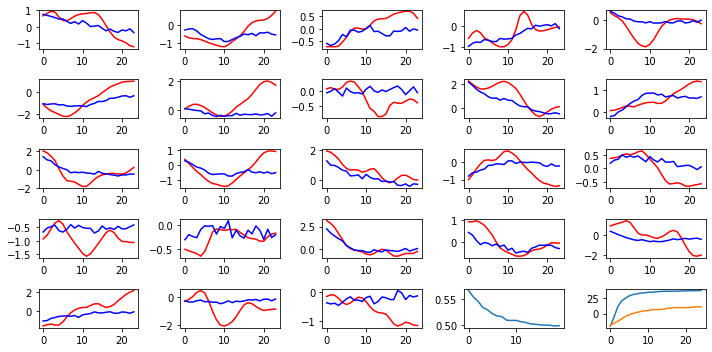

Step: 0, Train Loss: 0.4180604815483093
Step: 20, Train Loss: 0.44779378175735474
Step: 40, Train Loss: 0.5029832720756531
Step: 60, Train Loss: 0.6088935136795044
Step: 80, Train Loss: 0.7549059391021729
Step: 100, Train Loss: 0.34492072463035583
Step: 120, Train Loss: 0.5076515674591064
Step: 140, Train Loss: 0.6714916229248047
Epoch: 26, Train loss: 0.49424946675561876
acskill_socre:52.30688071469431, rmse_score:15.395336583037981
acskill_socre:27.59863715147518, rmse_score:17.04735615900709
Epoch: 26, Valid Score: 36.91154413165633, Valid Score 2: 10.55128099246809



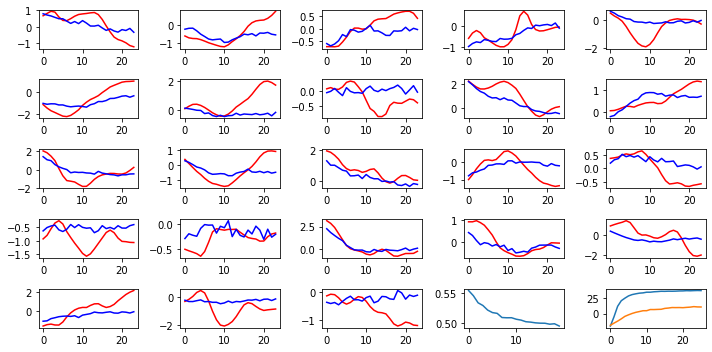

Step: 0, Train Loss: 0.42693012952804565
Step: 20, Train Loss: 0.37642091512680054
Step: 40, Train Loss: 0.4269039034843445
Step: 60, Train Loss: 0.5579243898391724
Step: 80, Train Loss: 0.5913783311843872
Step: 100, Train Loss: 0.5623762011528015
Step: 120, Train Loss: 0.6175282001495361
Step: 140, Train Loss: 0.5089577436447144
Epoch: 27, Train loss: 0.4952014543830532
acskill_socre:52.405974665185155, rmse_score:15.373699855364018
acskill_socre:27.65121220403762, rmse_score:17.079678709822776
Epoch: 27, Valid Score: 37.03227480982114, Valid Score 2: 10.571533494214844



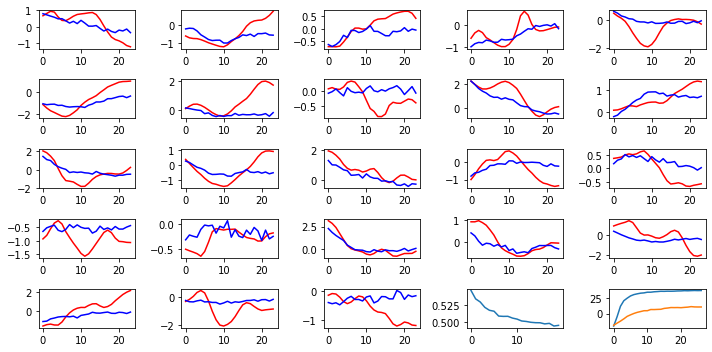

Step: 0, Train Loss: 0.5912826061248779
Step: 20, Train Loss: 0.4657263159751892
Step: 40, Train Loss: 0.6188040375709534
Step: 60, Train Loss: 0.552492618560791
Step: 80, Train Loss: 0.5810040831565857
Step: 100, Train Loss: 0.43326088786125183
Step: 120, Train Loss: 0.34515342116355896
Step: 140, Train Loss: 0.3420831561088562
Epoch: 28, Train loss: 0.49331349869296975
acskill_socre:52.531318872958174, rmse_score:15.336430927722644
acskill_socre:27.610947112200257, rmse_score:17.114010365512105
Epoch: 28, Valid Score: 37.19488794523553, Valid Score 2: 10.496936746688153

Model saved successfully


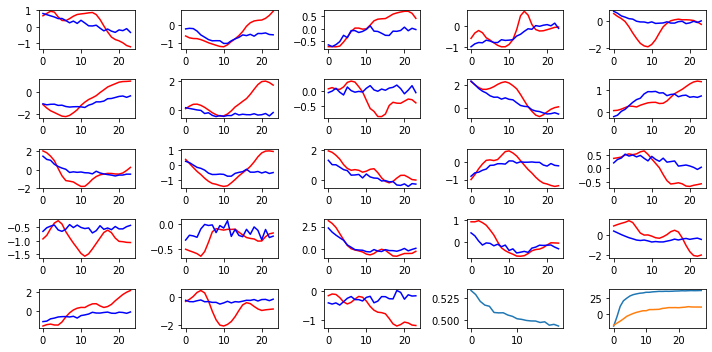

Step: 0, Train Loss: 0.4928685426712036
Step: 20, Train Loss: 0.5995113253593445
Step: 40, Train Loss: 0.6025373935699463
Step: 60, Train Loss: 0.9121197462081909
Step: 80, Train Loss: 0.39202994108200073
Step: 100, Train Loss: 0.3851897120475769
Step: 120, Train Loss: 0.31989115476608276
Step: 140, Train Loss: 0.6395177841186523
Epoch: 29, Train loss: 0.49743420457186766
acskill_socre:52.290095004793685, rmse_score:15.33308002268341
acskill_socre:28.764056350421598, rmse_score:16.875130822998155
Epoch: 29, Valid Score: 36.95701498211027, Valid Score 2: 11.888925527423442



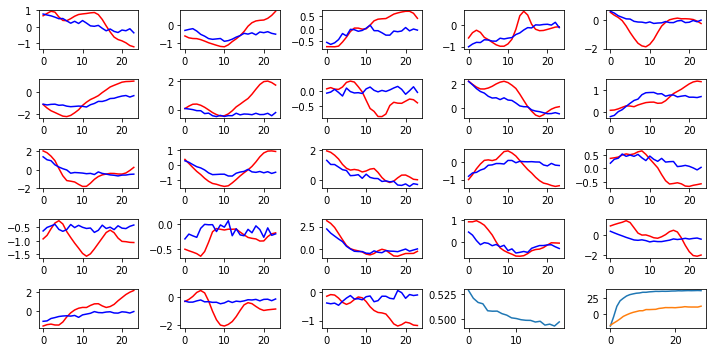

Step: 0, Train Loss: 0.5168086886405945
Step: 20, Train Loss: 0.399537056684494
Step: 40, Train Loss: 0.35401198267936707
Step: 60, Train Loss: 0.5369979739189148
Step: 80, Train Loss: 0.5005587935447693
Step: 100, Train Loss: 0.4452597498893738
Step: 120, Train Loss: 0.6131013631820679
Step: 140, Train Loss: 0.541343629360199
Epoch: 30, Train loss: 0.49460199291575446
acskill_socre:52.41633728549324, rmse_score:15.382827147869884
acskill_socre:28.130573075414578, rmse_score:16.98252943562292
Epoch: 30, Valid Score: 37.03351013762336, Valid Score 2: 11.14804363979166



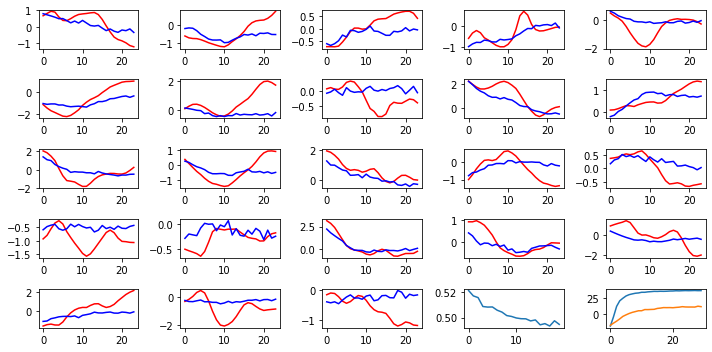

Step: 0, Train Loss: 0.43618959188461304
Step: 20, Train Loss: 0.6849936246871948
Step: 40, Train Loss: 0.5411620736122131
Step: 60, Train Loss: 0.5499863624572754
Step: 80, Train Loss: 0.4368053078651428
Step: 100, Train Loss: 0.6741398572921753
Step: 120, Train Loss: 0.4793739318847656
Step: 140, Train Loss: 0.3385171890258789
Epoch: 31, Train loss: 0.4955934816843843
acskill_socre:52.58901598918604, rmse_score:15.334961033901555
acskill_socre:28.886896506842504, rmse_score:16.807128321469403
Epoch: 31, Valid Score: 37.25405495528448, Valid Score 2: 12.079768185373101

Model saved successfully


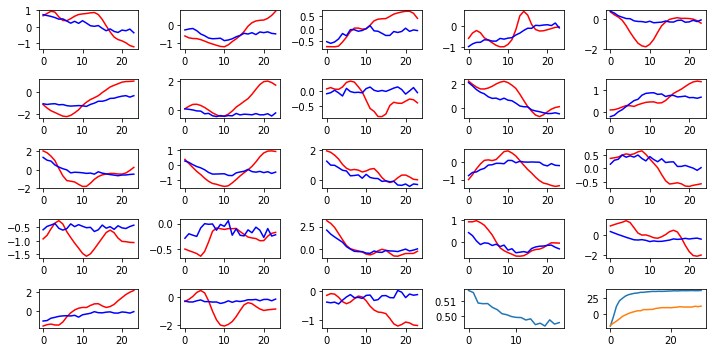

Step: 0, Train Loss: 0.39824533462524414
Step: 20, Train Loss: 0.4659171998500824
Step: 40, Train Loss: 0.7649586200714111
Step: 60, Train Loss: 0.5322813391685486
Step: 80, Train Loss: 0.5323550701141357
Step: 100, Train Loss: 0.42265328764915466
Step: 120, Train Loss: 0.5605274438858032
Step: 140, Train Loss: 0.5029920339584351
Epoch: 32, Train loss: 0.4926829948408963
acskill_socre:52.29051362606919, rmse_score:15.358048957645927
acskill_socre:28.882804338765048, rmse_score:16.892577146268675
Epoch: 32, Valid Score: 36.932464668423265, Valid Score 2: 11.990227192496373



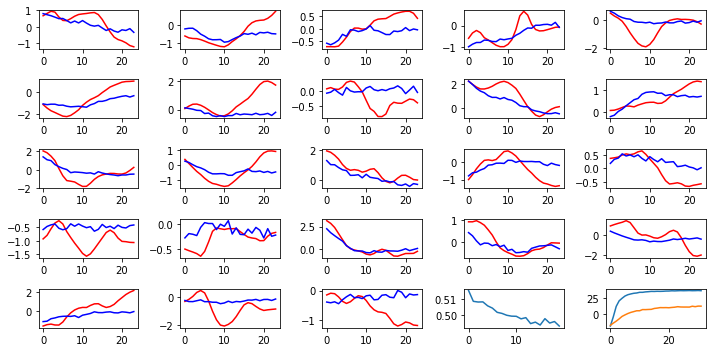

Step: 0, Train Loss: 0.4386743903160095
Step: 20, Train Loss: 0.4618440270423889
Step: 40, Train Loss: 0.4120238423347473
Step: 60, Train Loss: 0.3979223966598511
Step: 80, Train Loss: 0.5390409231185913
Step: 100, Train Loss: 0.3842167854309082
Step: 120, Train Loss: 0.455739825963974
Step: 140, Train Loss: 0.7207009792327881
Epoch: 33, Train loss: 0.4920253814899758
acskill_socre:52.74768989421892, rmse_score:15.310663958621088
acskill_socre:28.30047565024596, rmse_score:16.98880620813767
Epoch: 33, Valid Score: 37.43702593559783, Valid Score 2: 11.31166944210829

Model saved successfully


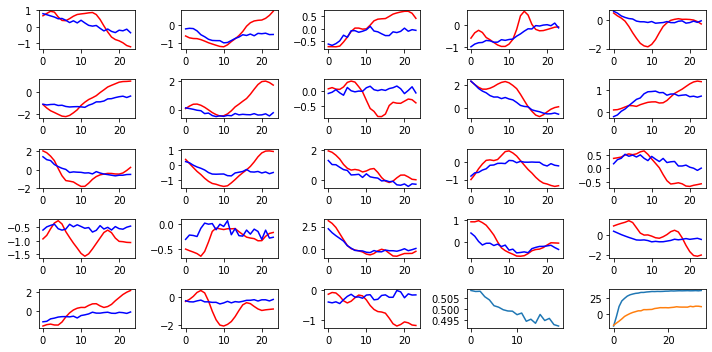

Step: 0, Train Loss: 0.4624999463558197
Step: 20, Train Loss: 0.6519272327423096
Step: 40, Train Loss: 0.41134244203567505
Step: 60, Train Loss: 0.6947562098503113
Step: 80, Train Loss: 0.4514537751674652
Step: 100, Train Loss: 0.5717720985412598
Step: 120, Train Loss: 0.35674747824668884
Step: 140, Train Loss: 0.58345627784729
Epoch: 34, Train loss: 0.4935791212810229
acskill_socre:52.917582114967985, rmse_score:15.261643363850009
acskill_socre:28.50505919148739, rmse_score:16.922317514001616
Epoch: 34, Valid Score: 37.65593875111797, Valid Score 2: 11.582741677485775

Model saved successfully


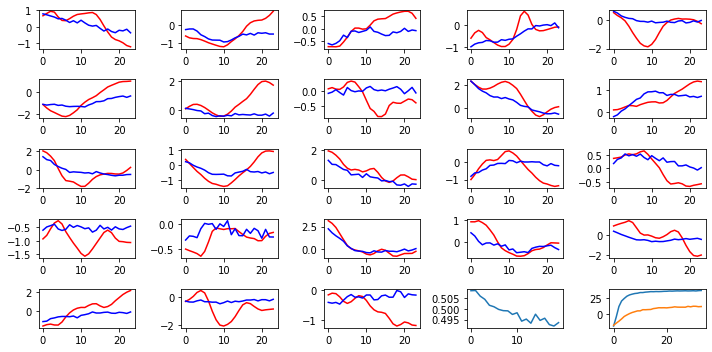

Step: 0, Train Loss: 0.4000033140182495
Step: 20, Train Loss: 0.47925853729248047
Step: 40, Train Loss: 0.5268444418907166
Step: 60, Train Loss: 0.5898500680923462
Step: 80, Train Loss: 0.36205625534057617
Step: 100, Train Loss: 0.49251776933670044
Step: 120, Train Loss: 0.49572449922561646
Step: 140, Train Loss: 0.3883041739463806
Epoch: 35, Train loss: 0.4922501802036207
acskill_socre:52.82465563359297, rmse_score:15.320270369275244
acskill_socre:28.204735477770477, rmse_score:16.96679371464616
Epoch: 35, Valid Score: 37.504385264317726, Valid Score 2: 11.237941763124319



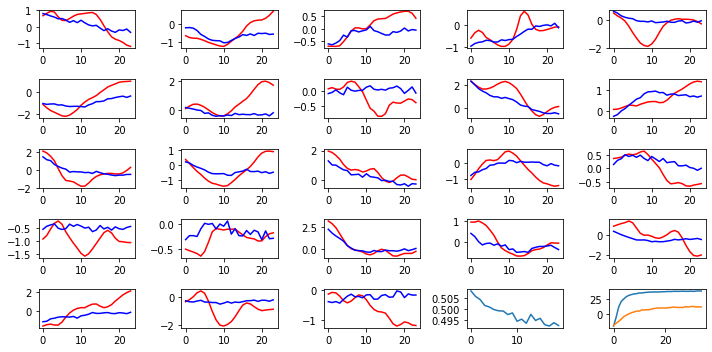

Step: 0, Train Loss: 0.3791773021221161
Step: 20, Train Loss: 0.4346442222595215
Step: 40, Train Loss: 0.5371519327163696
Step: 60, Train Loss: 0.3811115622520447
Step: 80, Train Loss: 0.6471580266952515
Step: 100, Train Loss: 0.5579918622970581
Step: 120, Train Loss: 0.5952484607696533
Step: 140, Train Loss: 0.545255720615387
Epoch: 36, Train loss: 0.4964485031692949
acskill_socre:52.660507263220644, rmse_score:15.298832613273674
acskill_socre:28.958688565498466, rmse_score:16.8318764055041
Epoch: 36, Valid Score: 37.36167464994697, Valid Score 2: 12.126812159994365



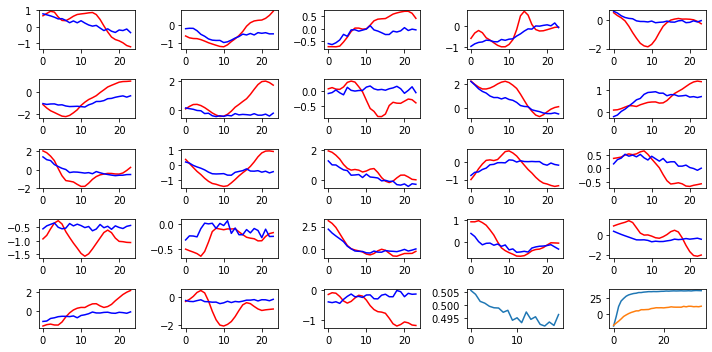

Step: 0, Train Loss: 0.4003639221191406
Step: 20, Train Loss: 0.516776978969574
Step: 40, Train Loss: 0.5359308123588562
Step: 60, Train Loss: 0.6264746189117432
Step: 80, Train Loss: 0.4594343602657318
Step: 100, Train Loss: 0.4908519685268402
Step: 120, Train Loss: 0.4848182797431946
Step: 140, Train Loss: 0.4972810745239258
Epoch: 37, Train loss: 0.4936591580714265
acskill_socre:52.7622764684231, rmse_score:15.287898710261492
acskill_socre:29.123074581862042, rmse_score:16.8026858518742
Epoch: 37, Valid Score: 37.47437775816161, Valid Score 2: 12.32038872998784



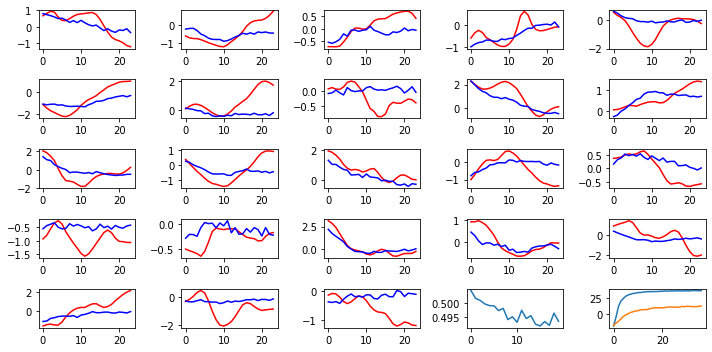

Step: 0, Train Loss: 0.46255144476890564
Step: 20, Train Loss: 0.31967613101005554
Step: 40, Train Loss: 0.6205344200134277
Step: 60, Train Loss: 0.453488826751709
Step: 80, Train Loss: 0.520767867565155
Step: 100, Train Loss: 0.44317007064819336
Step: 120, Train Loss: 0.5057411789894104
Step: 140, Train Loss: 0.4901265501976013
Epoch: 38, Train loss: 0.4924637546686277
acskill_socre:52.731660143760365, rmse_score:15.298042627835208
acskill_socre:28.98486422178927, rmse_score:16.898432116401757
Epoch: 38, Valid Score: 37.43361751592516, Valid Score 2: 12.086432105387512



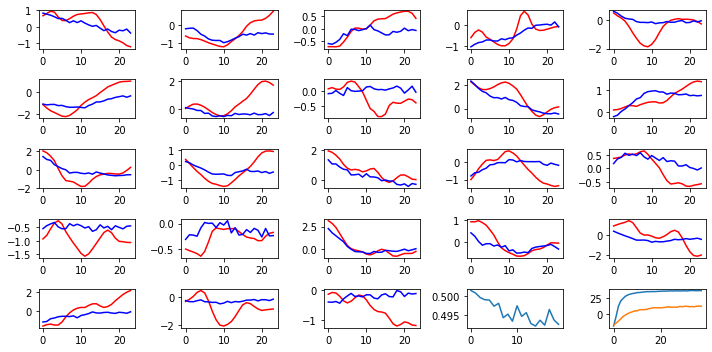

Step: 0, Train Loss: 0.3294271230697632
Step: 20, Train Loss: 0.4658389091491699
Step: 40, Train Loss: 0.5309798121452332
Step: 60, Train Loss: 0.4942880868911743
Step: 80, Train Loss: 0.6433477997779846
Step: 100, Train Loss: 0.6798828840255737
Step: 120, Train Loss: 0.40216273069381714
Step: 140, Train Loss: 0.3647395968437195
Epoch: 39, Train loss: 0.4919701581948424
acskill_socre:53.16286724729402, rmse_score:15.238560549140086
acskill_socre:28.937673361096387, rmse_score:16.89544709414504
Epoch: 39, Valid Score: 37.92430669815393, Valid Score 2: 12.042226266951346

Model saved successfully


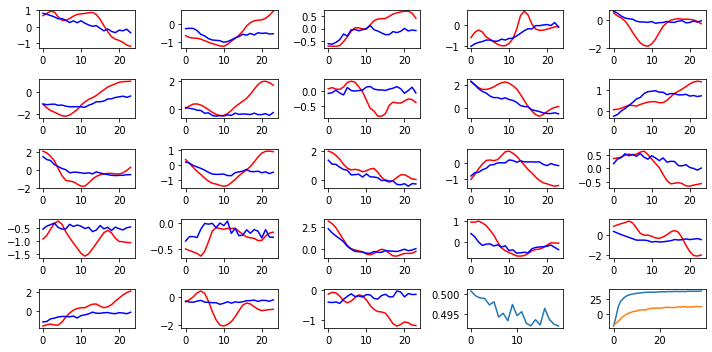

Step: 0, Train Loss: 0.3345005512237549
Step: 20, Train Loss: 0.6706123352050781
Step: 40, Train Loss: 0.6371452808380127
Step: 60, Train Loss: 0.4655300974845886
Step: 80, Train Loss: 0.37711820006370544
Step: 100, Train Loss: 0.49460315704345703
Step: 120, Train Loss: 0.38100242614746094
Step: 140, Train Loss: 0.4708731174468994
Epoch: 40, Train loss: 0.4918553657727699
acskill_socre:53.060081516873964, rmse_score:15.26813269157816
acskill_socre:28.863312094296663, rmse_score:16.904448733659894
Epoch: 40, Valid Score: 37.791948825295805, Valid Score 2: 11.95886336063677



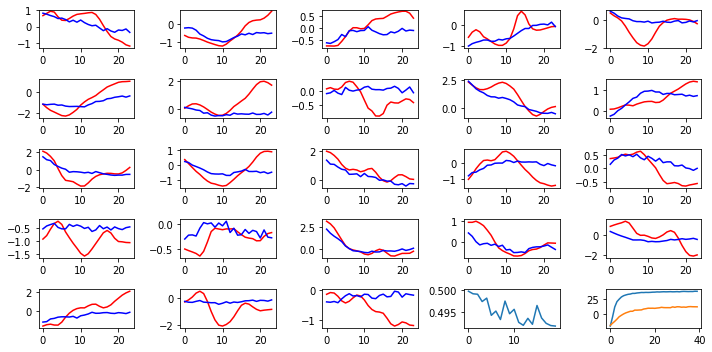

Step: 0, Train Loss: 0.46461233496665955
Step: 20, Train Loss: 0.40778255462646484
Step: 40, Train Loss: 0.5981277227401733
Step: 60, Train Loss: 0.4138050973415375
Step: 80, Train Loss: 0.43682047724723816
Step: 100, Train Loss: 0.7093952894210815
Step: 120, Train Loss: 0.4396227300167084
Step: 140, Train Loss: 0.5954501628875732
Epoch: 41, Train loss: 0.4917671653914125
acskill_socre:52.89334850369642, rmse_score:15.2651698614325
acskill_socre:29.32898365953405, rmse_score:16.792240882797422
Epoch: 41, Valid Score: 37.62817864226392, Valid Score 2: 12.536742776736627



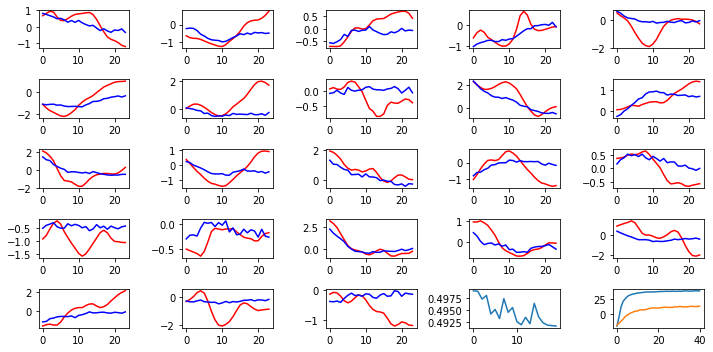

Step: 0, Train Loss: 0.46295294165611267
Step: 20, Train Loss: 0.5567996501922607
Step: 40, Train Loss: 0.5284305810928345
Step: 60, Train Loss: 0.4780829846858978
Step: 80, Train Loss: 0.3660908341407776
Step: 100, Train Loss: 0.3988499641418457
Step: 120, Train Loss: 0.4734519422054291
Step: 140, Train Loss: 0.6562272310256958
Epoch: 42, Train loss: 0.48756305750918716
acskill_socre:52.9863990612111, rmse_score:15.265816582216827
acskill_socre:28.597513808827177, rmse_score:16.926236284053594
Epoch: 42, Valid Score: 37.720582478994274, Valid Score 2: 11.671277524773583



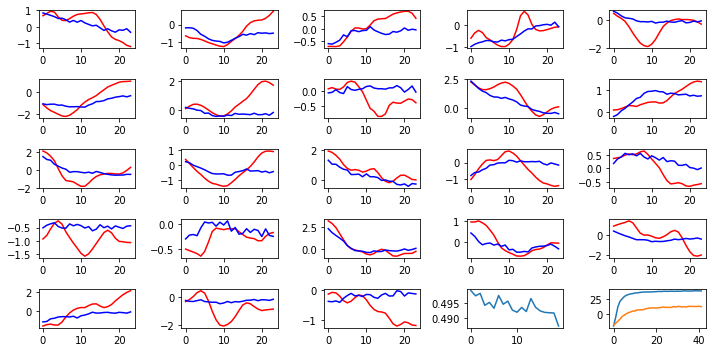

Step: 0, Train Loss: 0.4231536388397217
Step: 20, Train Loss: 0.4834234118461609
Step: 40, Train Loss: 0.5062994360923767
Step: 60, Train Loss: 0.3429492712020874
Step: 80, Train Loss: 0.5177061557769775
Step: 100, Train Loss: 0.4324209690093994
Step: 120, Train Loss: 0.5561898946762085
Step: 140, Train Loss: 0.6564295887947083
Epoch: 43, Train loss: 0.49021582856570206
acskill_socre:52.97594309657377, rmse_score:15.255799806320201
acskill_socre:29.000222283452334, rmse_score:16.828678574188846
Epoch: 43, Valid Score: 37.720143290253574, Valid Score 2: 12.171543709263489



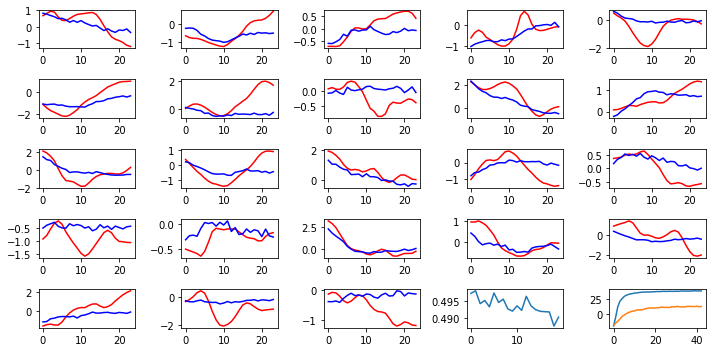

Step: 0, Train Loss: 0.40776175260543823
Step: 20, Train Loss: 0.543397068977356
Step: 40, Train Loss: 0.7266985177993774
Step: 60, Train Loss: 0.428145170211792
Step: 80, Train Loss: 0.4174034595489502
Step: 100, Train Loss: 0.4756273031234741
Step: 120, Train Loss: 0.4443574547767639
Step: 140, Train Loss: 0.468723863363266
Epoch: 44, Train loss: 0.491602849470426
acskill_socre:52.958641331144165, rmse_score:15.27563730736987
acskill_socre:28.549098200367954, rmse_score:16.92370913341676
Epoch: 44, Valid Score: 37.683004023774295, Valid Score 2: 11.625389066951193



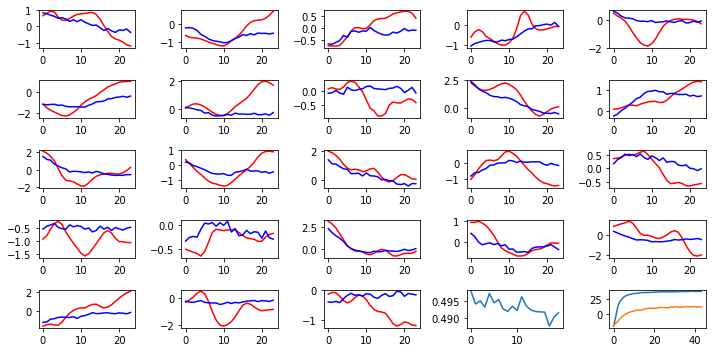

Step: 0, Train Loss: 0.4868934154510498
Step: 20, Train Loss: 0.3199516832828522
Step: 40, Train Loss: 0.5197865962982178
Step: 60, Train Loss: 0.5254821181297302
Step: 80, Train Loss: 0.500436544418335
Step: 100, Train Loss: 0.5511157512664795
Step: 120, Train Loss: 0.40830540657043457
Step: 140, Train Loss: 0.4202641248703003
Epoch: 45, Train loss: 0.4899060936415032
acskill_socre:52.976284551468794, rmse_score:15.23488831748678
acskill_socre:29.341314834244166, rmse_score:16.803774950580983
Epoch: 45, Valid Score: 37.741396233982016, Valid Score 2: 12.537539883663182



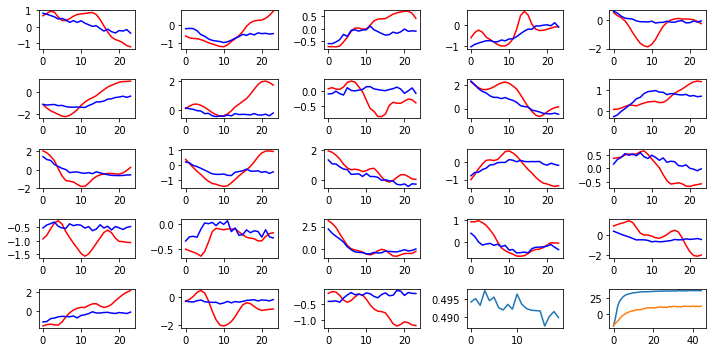

Step: 0, Train Loss: 0.4735215902328491
Step: 20, Train Loss: 0.5125364661216736
Step: 40, Train Loss: 0.5258123278617859
Step: 60, Train Loss: 0.5633286237716675
Step: 80, Train Loss: 0.47584307193756104
Step: 100, Train Loss: 0.38853177428245544
Step: 120, Train Loss: 0.3768305778503418
Step: 140, Train Loss: 0.34416478872299194
Epoch: 46, Train loss: 0.4872044551454178
acskill_socre:53.129109950494765, rmse_score:15.227024790145212
acskill_socre:28.753997564832762, rmse_score:16.904468127688386
Epoch: 46, Valid Score: 37.90208516034956, Valid Score 2: 11.849529437144376



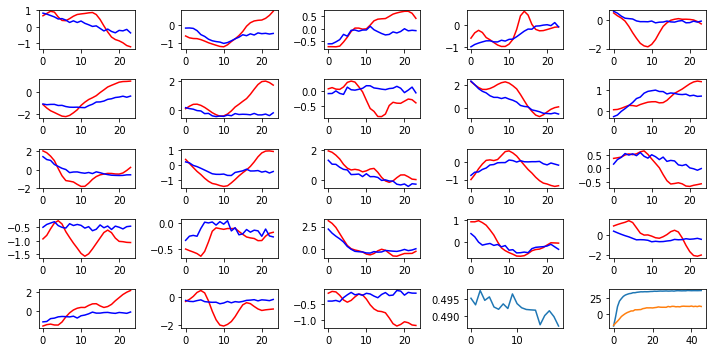

Step: 0, Train Loss: 0.5373567342758179
Step: 20, Train Loss: 0.3890121877193451
Step: 40, Train Loss: 0.4705323576927185
Step: 60, Train Loss: 0.5829340219497681
Step: 80, Train Loss: 0.4628915786743164
Step: 100, Train Loss: 0.4378370940685272
Step: 120, Train Loss: 0.6477034091949463
Step: 140, Train Loss: 0.5216695666313171
Epoch: 47, Train loss: 0.4883350750354871
acskill_socre:53.221556521935895, rmse_score:15.213426346810664
acskill_socre:29.404331968215434, rmse_score:16.773448632646407
Epoch: 47, Valid Score: 38.00813017512523, Valid Score 2: 12.630883335569028

Model saved successfully


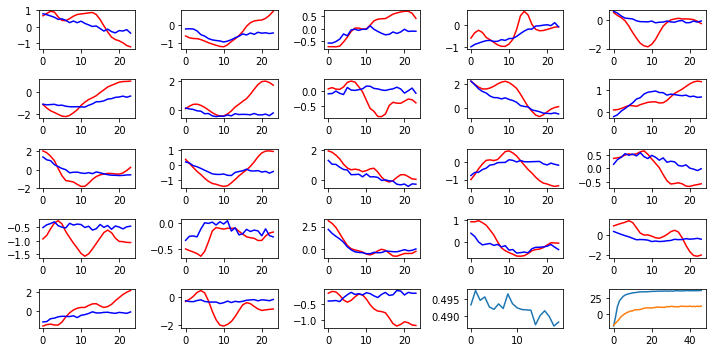

Step: 0, Train Loss: 0.4369376301765442
Step: 20, Train Loss: 0.4493580758571625
Step: 40, Train Loss: 0.5192587971687317
Step: 60, Train Loss: 0.5543011426925659
Step: 80, Train Loss: 0.5606656074523926
Step: 100, Train Loss: 0.4385718107223511
Step: 120, Train Loss: 0.4364928901195526
Step: 140, Train Loss: 0.39687538146972656
Epoch: 48, Train loss: 0.48734313555776254
acskill_socre:53.206058267326206, rmse_score:15.18516153786097
acskill_socre:29.466091184134292, rmse_score:16.800617819285925
Epoch: 48, Valid Score: 38.020896729465235, Valid Score 2: 12.665473364848367

Model saved successfully


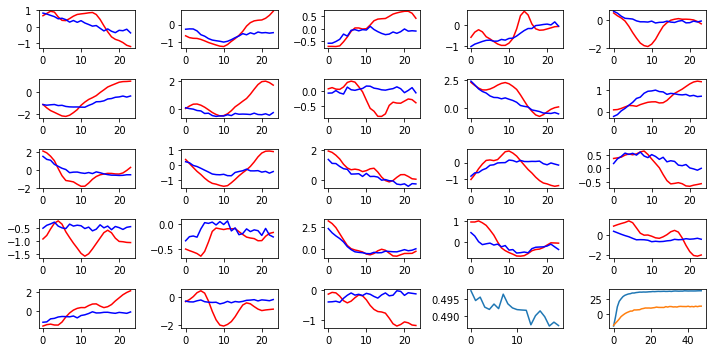

Step: 0, Train Loss: 0.47840389609336853
Step: 20, Train Loss: 0.675116777420044
Step: 40, Train Loss: 0.6814433932304382
Step: 60, Train Loss: 0.5598304271697998
Step: 80, Train Loss: 0.5282163023948669
Step: 100, Train Loss: 0.5323814153671265
Step: 120, Train Loss: 0.40172362327575684
Step: 140, Train Loss: 0.6239794492721558
Epoch: 49, Train loss: 0.48680515546504766
acskill_socre:53.24163039354832, rmse_score:15.216001667199448
acskill_socre:29.365332607728163, rmse_score:16.72816793772381
Epoch: 49, Valid Score: 38.02562872634887, Valid Score 2: 12.637164670004353

Model saved successfully


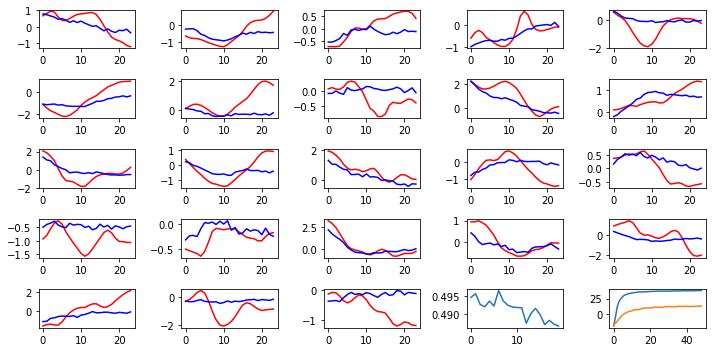

Step: 0, Train Loss: 0.4695485234260559
Step: 20, Train Loss: 0.44095417857170105
Step: 40, Train Loss: 0.4995778799057007
Step: 60, Train Loss: 0.4515376091003418
Step: 80, Train Loss: 0.41692203283309937
Step: 100, Train Loss: 0.42560768127441406
Step: 120, Train Loss: 0.3115110695362091
Step: 140, Train Loss: 0.5313607454299927
Epoch: 50, Train loss: 0.48906915032700315
acskill_socre:53.335837175374735, rmse_score:15.211385066397604
acskill_socre:28.842157289155217, rmse_score:16.825742359825156
Epoch: 50, Valid Score: 38.12445210897713, Valid Score 2: 12.016414929330061

Model saved successfully


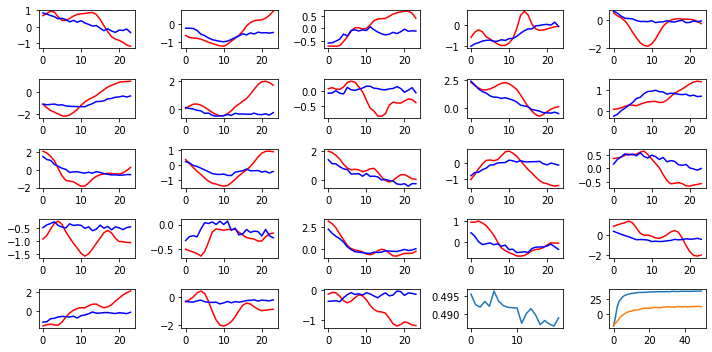

max score: 38.12445210897713 at eopch 50
max score 2: 12.665473364848367 at eopch 48


In [29]:
train(num_epochs=50)

In [16]:
# model.load_state_dict(torch.load('models/basemodel_best.pt'))

In [17]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [18]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
#     data_list = [SST,T300,Ua,Va]
#     SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

In [19]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [20]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [21]:
make_zip()